In [1]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, cascadelake)
Environment:
  JULIA_NUM_THREADS = 4
      Status `/mnt/efs/kai/projects/AdvancedHMC.jl/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.0 `../..#kx/rhmc-draft`
  [863f3e99] Comonicon v1.0.4
  [31c24e10] Distributions v0.24.18
  [366bfd00] DynamicPPL v0.10.20
  [6a86dc24] FiniteDiff v2.17.0
  [6d524b87] MCMCDebugging v0.2.0
  [91a5bcdd] Plots v1.38.6
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.9.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl#main`


In [2]:
using PyPlot: PyPlot; const plt = PyPlot
using Statistics, AdvancedHMC
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc-sampler.jl")

┌ Warning: skipping callee #step#10 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils /home/kai/.julia/packages/LoweredCodeUtils/0oUEK/src/signatures.jl:292


Baseline: HMC with dense but identity Euclidean metric

In [3]:
hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, integrator=:lf, ϵ=0.1, n=6, L=8)
retval = sample_target((; hps...))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.030489277 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, Leapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=Leapfrog(ϵ=0.1), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
│   average_acceptance_rate = 0.9990870349279157
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059172875182715856, 0.020223117668237246]
│   var(retval.samples) = [0.9466621835679574, 0.9267189667568049]
└ @ Main In[3]:4


Check if generalized leapfrog works fine

In [4]:
retval = sample_target((; hps..., integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.179509026 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
│   average_acceptance_rate = 0.9990870349279157
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059172875182715856, 0.020223117668237246]
│   var(retval.samples) = [0.9466621835679574, 0.9267189667568049]
└ @ Main In[4]:3


Check if RHMC (with Fisher metric) works (on Gaussian)

In [5]:
@time retval = sample_target((; hps..., metric=:dense_riemannian, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 94.302141 seconds (652.98 M allocations: 26.186 GiB, 10.71% gc time, 13.22% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 86.353698142 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
│   average_acceptance_rate = 0.9990997411969952
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059494248703613806, 0.0203247508084654]
│   var(retval.samples) = [0.9465345660813427, 0.9260461275621712]
└ @ Main In[5]:3


Check if RHMC (with Fisher metric) works for Neal's funnel

In [6]:
using Logging: NullLogger, with_logger

@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

LoadError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

Check if RHMC with SoftAbs works for Gaussian

In [7]:
@time retval = sample_target((; hps..., metric=:dense_riemannian_softabs, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 33.606645 seconds (234.31 M allocations: 9.846 GiB, 7.80% gc time, 23.53% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 27.032108198 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
│   average_acceptance_rate = 0.9990997411969952
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/sampler.jl:214
┌ Info: Samples
│   mean(retval.samples) = [-0.059494248703613806, 0.0203247508084654]
│   var(retval.samples) = [0.9465345660813427, 0.9260461275621712]
└ @ Main In[7]:3


Check if RHMC with SoftAbs works for Neal's funnel

 69.331389 seconds (444.38 M allocations: 19.144 GiB, 6.80% gc time, 3.92% compilation time)


┌ Info: Average acceptance ratio
│   mean(map((s->begin
                #= In[8]:5 =#
                s.is_accept
            end), retval.stats)) = 0.5915
└ @ Main In[8]:5


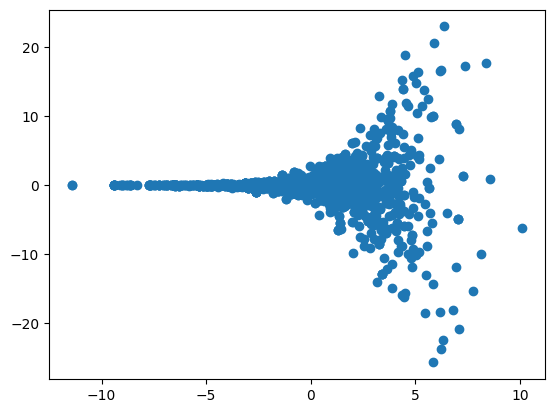

In [8]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.2))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

speed through optimization
- unoptimized: 200s
- +cache 1st loop: 82s
- +cache 2nd loop: 77s
- -copy in ad: 75s

Check if the Hessian is (semi)-PD for Neal's funnel

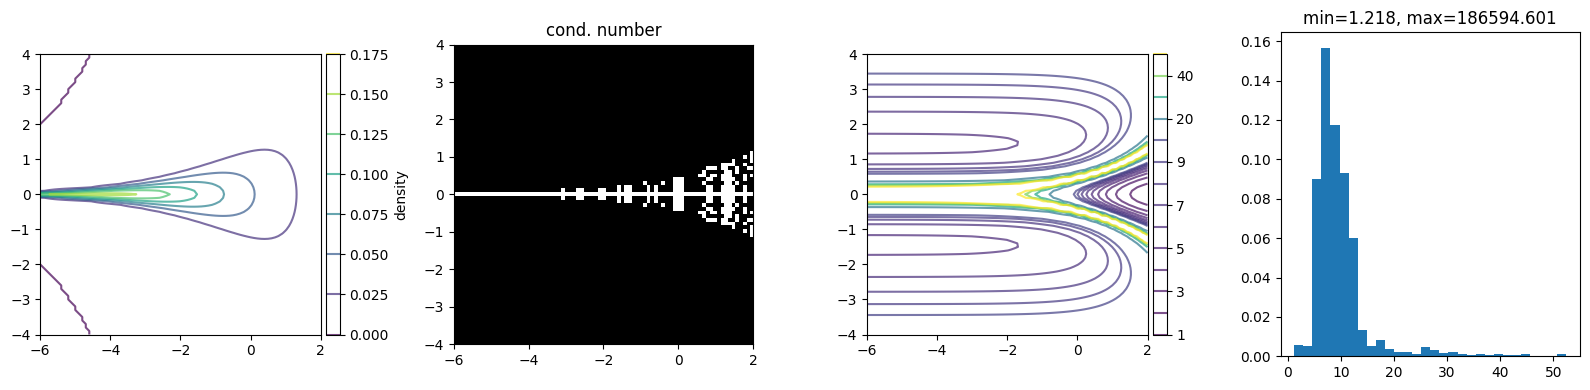

In [9]:
using PyCall: pyimport
using LinearAlgebra: issuccess, cond
using Printf: @sprintf
const axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

isposdef_pivot(A) = issuccess(cholesky(A, Val(true), check=false))

function make_Z(Gfunc, f, λ=0.0)
    is = -6:0.1:+2
    js = -4:0.1:+4
    X = Matrix{Float64}(undef, length(is), length(js))
    Y = Matrix{Float64}(undef, length(is), length(js))
    logdensity = Matrix{Float64}(undef, length(is), length(js))
    Z = Matrix(undef, length(is), length(js))
    for (i, iv) in enumerate(is), (j, jv) in enumerate(js)
        v, _, G = Gfunc([iv, jv])
        X[i,j] = iv
        Y[i,j] = jv
        logdensity[i,j] = exp(-v)
        # PD[i,j] = isposdef(H + λ * I)
        Z[i,j] = f(G + λ * I)
    end
    return logdensity, X, Y, Z
end

function plot_contour!(ax, X, Y, Z, label=nothing; kwargs...)
    contour = ax.contour(X, Y, Z, alpha=0.7; kwargs...)
    divider = axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contour, cax=cax, ax=ax, orientation="vertical")
    isnothing(label) || cbar.set_label(label)
    ax.axis("equal")
end

# Check which region gives non-positive definite for Neal's funnel
let target = Funnel(), 
    rng = MersenneTwister(1110), 
    
    D = dim(target)
    initial_θ = rand(rng, D)
    Vfunc = x -> -logpdf(target, x)
    Gfunc = VecTargets.gen_hess(Vfunc, initial_θ)
    
    logdensity, X, Y, PD = make_Z(Gfunc, isposdef_pivot)
    _, _, _, C = make_Z(Gfunc, cond)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4; figsize=(4 * 4, 4), tight_layout=true); plt.close(fig)
    
    plot_contour!(ax1, X, Y, logdensity, "density")
    
    ax2.imshow(PD', cmap=plt.cm.gray; interpolation="nearest", extent=[extrema(X)..., extrema(Y)...]) 
    ax2.set_title("is PD? black=0, white=1")
    
    Cvec = vec(C)
    Cv95 = quantile(Cvec, 0.95) # ignoring outliers
    
    plot_contour!(ax3, X, Y, C; levels=[1:9..., 10:10:50...])
    ax2.set_title("cond. number")
    
    ax4.hist(Cvec[Cvec .< Cv95]; bins=30, density=true)
    minstr = @sprintf("%.3f", minimum(Cvec))
    maxstr = @sprintf("%.3f", maximum(Cvec))
    ax4.set_title("min=$minstr, max=$maxstr")
    
    fig
end